# Customer Segmentation


## Synopsis

Customer segmentation is the process of dividing customers into groups based on common characteristics. This is essential as it allows companies to market to each group effectively and appropriately. By marketing to each customer group differently, companies will be able to maximise their profits. To perform customer segmentation, we will be performing recency, frequency and monetary (RFM) analysis, followed by k-means clustering.

## Data

The data is taken from the UCI Machine Learning Repository and can be downloaded [here](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx). The data is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. It consists of 541909 rows and 8 columns and its details are shown below:

| Variable    | Description                                                                                                                                                 |
|-------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------|
| InvoiceNo   | Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation. |
| StockCode   | Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.                                                         |
| Description | Product (item) name. Nominal.                                                                                                                               |
| Quantity    | The quantities of each product (item) per transaction. Numeric.                                                                                             |
| InvoiceDate | Invoice Date and time. Numeric, the day and time when each transaction was generated.                                                                       |
| UnitPrice   | Unit price. Numeric, Product price per unit in sterling.                                                                                                    |
| CustomerID  | Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.                                                                     |
| Country     | Country name. Nominal, the name of the country where each customer resides.    

More details on the data can be seen [here](https://archive.ics.uci.edu/ml/datasets/online+retail#).

## Data Cleaning

Import the required libraries.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

Read in the input data, display its shape and observe its first few rows.

In [2]:
cus = pd.read_excel("Online Retail.xlsx")
cus.shape

(541909, 8)

In [3]:
cus.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Check for missing values.

In [4]:
cus.count()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

For purpose of analysis, we will only be examining customer purchases from the United Kingdom for 1 year, from 11 December 2010 to 11 December 2011. We also have to remove the null values from 'CustomerID' and 'Description', remove the orders which were cancelled (those with a 'C' in 'InvoiceNo') and remove the negative values from 'Quantity' and 'UnitPrice'.

In [5]:
cus_f = cus[
    (cus['Country']=='United Kingdom') &
    (cus['CustomerID'].notnull()) &
    (cus['Description'].notnull()) &
    (~cus["InvoiceNo"].str.contains("C",na=False)) &
    (cus['Quantity'] > 0) &
    (cus['UnitPrice'] > 0) &
    (cus['InvoiceDate'] >= "2010-12-11") & (cus['InvoiceDate'] < "2011-12-11")
]

Check the dimensions of the dataset after filtering.

In [6]:
cus_f.shape

(339702, 8)

Let's change the data types. We first define 'CustomerID' as categorical, but we need to change it to integer first. We also define 'StockCode' as categorical and convert the 'InvoiceDate' to a datetime type.

In [7]:
cus_f['CustomerID'] = pd.Categorical(cus_f['CustomerID'].astype(int))
cus_f['StockCode'] = pd.Categorical(cus_f['StockCode'])
cus_f['InvoiceDate'] = pd.to_datetime(cus_f['InvoiceDate'])
cus_f = cus_f.drop(['Country'], axis=1)

<ipython-input-7-2dffdd75e0fa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_f['CustomerID'] = pd.Categorical(cus_f['CustomerID'].astype(int))
<ipython-input-7-2dffdd75e0fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cus_f['StockCode'] = pd.Categorical(cus_f['StockCode'])
<ipython-input-7-2dffdd75e0fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

## Feature Engineering

The following 2 columns will be created:

- **InvoiceDay** - Day of the invoice

- **TotalSum** - Total amount customer spent for a particular item

In [8]:
cus_f['InvoiceDay'] = cus_f.InvoiceDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))
cus_f['TotalSum'] = cus_f.Quantity * cus_f.UnitPrice

## Exploratory Data Analysis

Check the most purchased items.

Text(0, 0.5, 'Total Quantity')

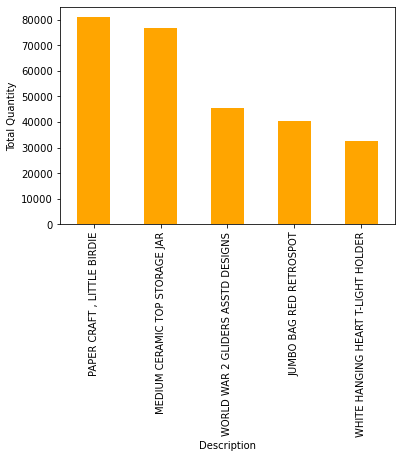

In [9]:
ax = cus_f.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head().plot(kind='bar',color='orange')
ax.set_ylabel('Total Quantity')

How many customers bought items over the year?

Text(0, 0.5, 'Number of Customers')

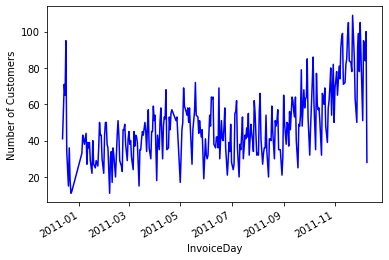

In [10]:
ax = cus_f.groupby('InvoiceDay')['CustomerID'].nunique().plot(kind='line', color='blue')
ax.set_ylabel('Number of Customers')

There seems to be more customers purchasing items during the year end holiday season.

How much was spent by customers over the year?

Text(0, 0.5, 'Amount Spent')

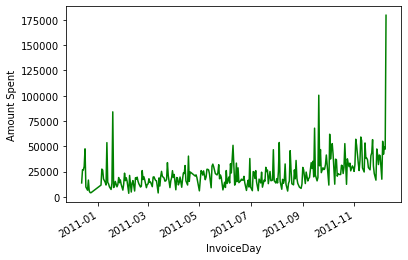

In [11]:
ax = cus_f.groupby('InvoiceDay')['TotalSum'].sum().plot(kind='line', color='green')
ax.set_ylabel('Amount Spent')

Check why the spike in the graph occurs.

In [12]:
cus_f['TotalSum'].max()

168469.6

In [13]:
cus_f[cus_f['TotalSum'] == 168469.6]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceDay,TotalSum
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,2011-12-09,168469.6


## Recency, Frequency, Monetary (RFM)

The following are the details of RFM analysis:

- **Recency** - The amount of time since last purchase

- **Frequency** - The total number of orders

- **Monetary** - The total amount spent

Calculate RFM values for each customer.

In [14]:
ref_date = max(cus_f.InvoiceDay) + dt.timedelta(1)
rfm = cus_f.groupby('CustomerID').agg({
     'InvoiceNo':'count',
     'TotalSum':'sum',
     'InvoiceDay': lambda x: ref_date - x.max()})

Rename the columns.

In [15]:
rfm.rename(columns={
     'InvoiceNo':'Frequency',
     'TotalSum':'Monetary',
     'InvoiceDay':'Recency'
 }, inplace=True)

Convert 'Recency' column to numerical.

In [16]:
rfm['Recency'] = rfm['Recency'].dt.days

In [17]:
rfm

,Frequency,Monetary,Recency
CustomerID,,,
12346,1,77183.60,326
12747,96,3837.45,3
12748,4051,30301.40,1
12749,199,4090.88,4
12820,59,942.34,4
...,...,...,...
18280,10,180.60,278
18281,7,80.82,181
18282,12,178.05,8


Apply log transformation to check the distributions of recency, frequency and monetary.

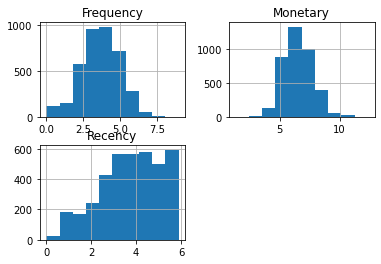

In [18]:
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1)
rfm_log.hist()
plt.show()

## Modelling

K-means clustering will be used to cluster the data. The algorithm is as follows:

**Step 1** - Select a suitable number of groups, k

**Step 2** - Randomly select k distinct data points, which will be called cluster centroids

**Step 3** - Assign every data point to the closest cluster centroid

**Step 4** - Move the cluster centroid to the average of the points in a cluster

**Step 5** - Repeat Steps 3 and 4 until there are no changes in the clusters

First, we need to determine a suitable value of k by creating a elbow plot.

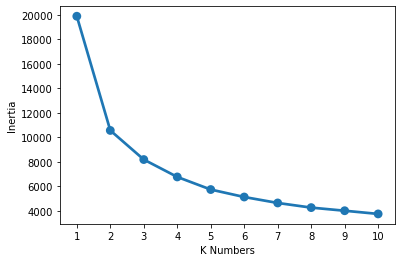

In [19]:
inertia = {}
for k in range(1,11):
    mod = KMeans(n_clusters=k)
    mod.fit(rfm_log)
    inertia[k] = mod.inertia_

sns.pointplot(x = list(inertia.keys()), y = list(inertia.values()))
plt.xlabel('K Numbers')
plt.ylabel('Inertia')
plt.show()

We select k=3 and build the model using k-means clustering with 3 clusters.

In [20]:
model = KMeans(n_clusters=3, random_state = 42)
model.fit(rfm_log)
rfm_log['cluster'] = model.predict(rfm_log)
rfm_log.head()

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346,5.786897,0.000000,11.253942,0
12747,1.098612,4.564348,8.252563,2
12748,0.000000,8.306719,10.318949,2
12749,1.386294,5.293305,8.316515,2
12820,1.386294,4.077537,6.848366,2


Plot a 3D scatterplot to observe the clusters.

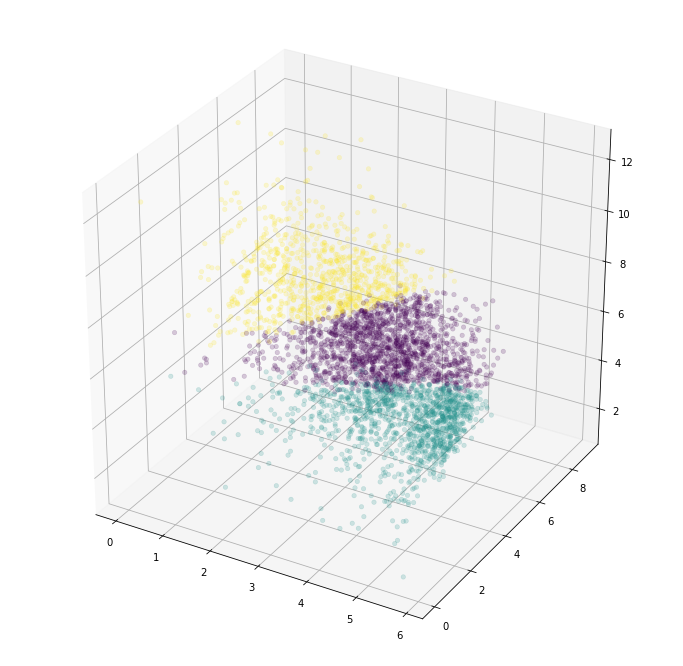

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
ax.scatter(rfm_log.Recency, rfm_log.Frequency, 
                        rfm_log.Monetary, c=rfm_log.cluster,
                        cmap='viridis', linewidth=0.5, alpha=0.2);
plt.show()

Let's compare the centroid values.

In [22]:
centroids_log = pd.DataFrame(model.cluster_centers_, columns=['Recency', 'Frequency', 'Monetary'])
centroids_log

,Recency,Frequency,Monetary
0,3.822030,3.949997,6.695534
1,4.791228,2.337495,5.396649
2,2.064102,5.082637,7.948802


Convert these centroid values back to the original scale.

In [23]:
centroids_orig = centroids_log.apply(np.exp, axis = 1).round(3)
centroids_orig

,Recency,Frequency,Monetary
0,45.697,51.935,808.786
1,120.449,10.355,220.666
2,7.878,161.199,2832.180


## Extracting the clusters

Let's obtain the small spending customers (high recency, low frequency, low monetary) and large spending customers (low recency, high frequency, high monetary).

In [24]:
small_customers = rfm_log[rfm_log.cluster == 1]
                         
small_customers = small_customers[['Recency', 'Frequency', 'Monetary']].apply(np.exp, axis = 1)
small_customers['Recency'] = np.rint(small_customers['Recency']).astype(int)
small_customers['Frequency'] = np.rint(small_customers['Frequency']).astype(int)
small_customers['Monetary'] = np.round(small_customers['Monetary'], 2)

In [25]:
small_customers

,Recency,Frequency,Monetary
CustomerID,,,
12821,215,6,92.72
12823,75,5,1759.50
12829,337,11,293.00
12831,263,9,215.05
12833,146,24,417.38
...,...,...,...
18277,59,8,110.38
18278,74,9,173.90
18280,278,10,180.60


In [26]:
large_customers = rfm_log[rfm_log.cluster == 0]

large_customers = large_customers[['Recency', 'Frequency', 'Monetary']].apply(np.exp, axis = 1)
large_customers['Recency'] = np.rint(large_customers['Recency']).astype(int)
large_customers['Frequency'] = np.rint(large_customers['Frequency']).astype(int)
large_customers['Monetary'] = np.round(large_customers['Monetary'], 2)

In [27]:
large_customers

,Recency,Frequency,Monetary
CustomerID,,,
12346,326,1,77183.60
12822,71,46,948.88
12824,60,25,397.12
12827,6,25,430.15
12830,38,38,6814.64
...,...,...,...
18260,173,134,2643.20
18261,44,21,324.24
18263,26,61,1213.16
